# Finding Genes Affected by Conditions with Patches

- This tutorial attempts to find wounding related genes using only the data originating from v3 sequencing runs contained in the [Vu (2022)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9901190/) dataset.

- The data is a combination of aged & young cells collected at time points 0DPW (uninjured), 4DPW and 7DPW.


- Throughout this tutorial, we will use the workflow package with Patches to find genes that are associated with the 4DPW timepoint. 

In [1]:
# Minimal mports
from ladder.data import get_data
from ladder.scripts import InterpretableWorkflow # Our workflow object to run the interpretable model
import umap, torch, pyro # To set seeds + umaps
import torch.optim as opt # For defining out optimizer


# For plotting
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For data loading
import anndata as ad
import scanpy as sc

# Formatting The Data

The workflows use [anndata](https://anndata.readthedocs.io/en/latest/) objects as input. Specifically, the data we provide can also be manually downloaded [here](https://drive.google.com/file/d/1quCP3403hOPG5Q8cy1KWZui_a0mJrQ5J/view?usp=drive_link). 

In [2]:
# Download the data object
get_data("Vu") 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57.5M/57.5M [00:00<00:00, 1.27GB/s]

Dataset saved at ./data/vu_2022_ay_wh.h5ad


In [3]:
# Load the anndata object
anndata = ad.read_h5ad("data/vu_2022_ay_wh.h5ad")
anndata

AnnData object with n_obs × n_vars = 31509 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'paper', 'time', 'age', 'seq', 'sample', 'percent.mt', 'RNA_snn_res.0.2', 'seurat_clusters', 'harmony_clusters', 'broad_type'

# Initializing the Interpretable Workflow
- Models can be run through two workflow interfaces: **InterpretableWorkflow** and **CrossConditionWorkflow** (see the corresponding [tutorial](about:blank))

- Once initialized, you can train and evaluate the model through the workflow interface. 

In [4]:
# Initialize workflow object
workflow = InterpretableWorkflow(anndata, verbose=True, random_seed=42)

# Define the condition classes & batch key to prepare the data
factors = ["time", "age"]
workflow.prep_model(factors, batch_key="sample", model_type='Patches')

# Train the model
workflow.run_model(max_epochs=300, convergence_threshold=5e-3) # Lower the convergence threshold if you need a more accurate model, will increase training time

Initialized workflow to run interpretable model.

Condition classes : ['time', 'age']
Number of attributes per class : [3, 2]

Initialized Patches model.
Model arguments: {'reconstruction': 'ZINB_LD', 'batch_correction': True, 'scale_factor': 2.6041666666666666e-06, 'num_labels': 5, 'len_attrs': [3, 2]}

Optimizer args parsed successfully. Final arguments: {'lr': 0.01, 'eps': 0.01, 'betas': (0.9, 0.999)}
Training initialized for a maximum of 300, with convergence eps 0.005.
Using device: cuda

Epoch : 0 || Train Loss: 2.14001 // 1.76374 || Test Loss: 1.69996 // 1.73869 || Warmup : False
Epoch : 1 || Train Loss: 1.32783 // 1.74383 || Test Loss: 1.0835 // 1.7364 || Warmup : False
Epoch : 2 || Train Loss: 0.99416 // 1.74404 || Test Loss: 0.91648 // 1.74747 || Warmup : False
Epoch : 3 || Train Loss: 0.91329 // 1.74463 || Test Loss: 0.86307 // 1.7443 || Warmup : False
Epoch : 4 || Train Loss: 0.87164 // 1.74503 || Test Loss: 0.84167 // 1.74561 || Warmup : False
Epoch : 5 || Train Loss: 0.84

## Observing the Losses

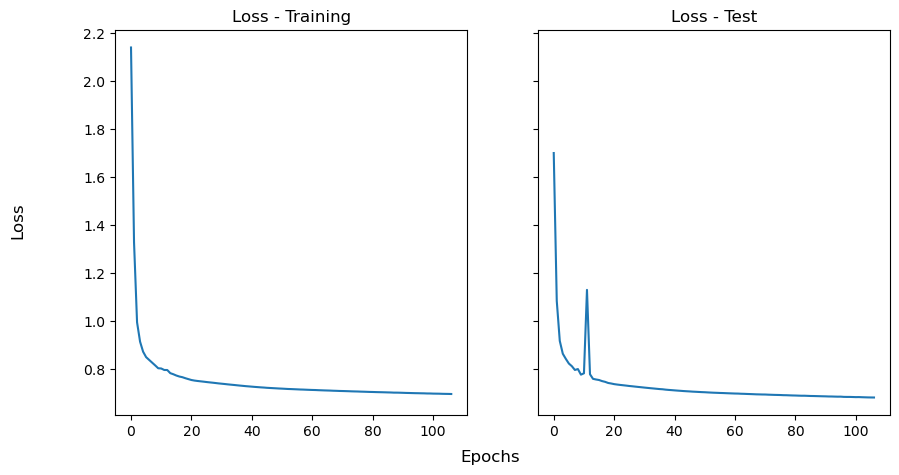

In [5]:
workflow.plot_loss()

## Obtaining Latent Embeddings

In [6]:
workflow.write_embeddings()
workflow.anndata.obsm

Written embeddings to object 'anndata.obsm' under workflow.


AxisArrays with keys: patches_w_latent, patches_z_latent

## Evaluation of Model Reconstruction

In [7]:
workflow.evaluate_reconstruction()

Calculating RMSE ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.15s/it]


Calculating Profile Correlation ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.12s/it]


Calculating 2-Sliced Wasserstein ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


Calculating Chamfer Discrepancy ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.82it/s]

Results
RMSE : 0.785 +- 0.0
Profile Correlation : 0.906 +- 0.0
2-Sliced Wasserstein : 0.32 +- 0.0
Chamfer Discrepancy : 0.393 +- 0.0


## Interpretability - Common and Conditional Gene Loadings

- Patches can generate condition-specific scores for each gene, describing the association of the gene and the condition, even if the conditions were always encountered combinatorially.

- Positive/Negative values mean that the given gene tends to be expressed relatively more/less for that condition compared to the basal state.

In [8]:
workflow.get_conditional_loadings()
workflow.get_common_loadings()
workflow.anndata.varm

Written condition specific loadings to 'self.anndata.var'.
Written common loadings to 'self.anndata.var'.


AxisArrays with keys: 

In [9]:
workflow.anndata.var

,0DPW_score_Patches,4DPW_score_Patches,7DPW_score_Patches,Aged_score_Patches,Young_score_Patches,common_score_Patches
Gene Names,,,,,,
Pcnp,-0.073716,-0.122502,-0.082946,0.062234,-0.018172,-0.077343
Jpt1,-0.070998,0.066587,-0.027407,0.095769,0.081088,0.241447
Rock2,0.133769,-0.027979,0.042045,-0.151226,-0.201409,0.037507
Mafg,-0.103028,0.297329,-0.050179,0.192225,0.234104,-0.009949
Serpinh1,-0.032279,-0.127060,-0.044676,-0.176405,0.159190,-0.250093
...,...,...,...,...,...,...
Slc31a2,-0.009911,0.326362,0.004632,0.178573,-0.011751,0.730762
Mef2c,0.054108,-0.066995,0.295107,-0.166251,0.113093,0.434323
Il1b,-0.254025,0.458105,0.366158,0.384907,0.498823,-0.275322


## Bonus

1. Run the cell below to get the top 200 genes
2. Copy & Paste the output to the [Gene Ontology Resource](https://geneontology.org/)
3. Select 'biological process' and 'Mus Musculus' from the list below and click launch.

In [10]:
for gene in workflow.anndata.var.sort_values("4DPW_score_Patches", ascending=False).index[:200]:
    print(gene)

Trib1
Stx11
Fcer1g
Nampt
Tnfaip2
Snx18
Smox
Ptprc
Marcksl1
Il1b
Nr4a1
Srgn
Ets2
Tyrobp
Atf3
Txnrd1
Ptgs2
Nfe2l2
Clk1
Gadd45a
Ezr
Ccl4
Basp1
Cd52
Cyba
Btg2
Tmcc1
Marcks
Slfn2
Tnfaip3
Ier3
Tnfrsf1b
Fem1c
Dazap2
Bcl2l11
Cd53
Ddx6
Ctsz
Efhd2
Rhog
Anxa11
Mxd1
Il10rb
Zeb2
Grina
Thbs1
Msrb1
Vps37b
Cstb
Cd82
Fxyd5
Emilin2
Bri3
Plekho2
Lmnb1
Jdp2
Kctd12
Rac1
Il1rn
Cd44
N4bp1
Lcp1
Hif1a
Sdcbp
Nfkbiz
Por
Actr2
Pim1
Npepps
Gadd45b
Sirpa
Maff
Hectd1
Arhgdib
Birc3
Rnf19b
Card19
Cotl1
Ppp1r15a
Klf7
Msn
Cox17
Pnrc1
Rel
Atp6v1c1
Fos
Nab1
Atp6v1e1
Sde2
Pgk1
Il1r2
Ifitm3
Vasp
Vamp2
App
Rnf149
Ppp1r10
Vmp1
Pde4b
Snx10
Tpd52
Ctsl
Tmem189
Gda
Igf1r
Stat3
Tspo
Hmox1
Slc44a1
Slc31a2
Abca1
2810474O19Rik
Klhl24
Tank
Arid5b
Ehd1
Tgoln1
Snx3
Map4k4
Rab8b
Wsb1
Vps4b
Ninj1
Tgif1
Tra2a
Nfkb1
Zfand5
Capza2
Atp6v0b
Plaur
Casp4
Arpc1b
Skil
Slc38a2
Litaf
Tgfb1
Atp6ap2
Cflar
Mapkapk2
Picalm
Fnip1
Creb1
Sqstm1
Mtmr6
Zc3hav1
Prdx5
Rbms1
Phlda1
Fgl2
Sat1
Ddx17
Vamp8
Sparc
Sf3b1
Atp2b1
Cux1
Mafg
Hilpda
Gsr
Tollip
Ddit3
Col1a